 ## **Import libaries**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

 ## **Data preparation**

In [ ]:
train_set = torchvision.datasets.MNIST(
    root= './data'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([ transforms.ToTensor() ])
)

test_set = torchvision.datasets.MNIST(
    root= './data'
    ,train=False
    ,download=True
    ,transform=transforms.Compose([ transforms.ToTensor() ])
)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100)


 ## **Build model**

In [ ]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5)
    self.fc1 = nn.Linear(in_features=16*12*12, out_features=50)
    self.out = nn.Linear(in_features=50, out_features=10)
  
  def forward(self,t):

    # (1) hidden conv layer
    t = F.max_pool2d( F.relu( self.conv1(t)), kernel_size=2, stride=2)
    
    # Flatten
    t = t.flatten(start_dim=1)
    
    # (2) hidden fc layer
    t = F.relu( self.fc1(t) )

    # (3) oytput layer
    t = F.relu( self.out(t) )

    return t

model = Model()
print(model)


Model(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=2304, out_features=50, bias=True)
  (out): Linear(in_features=50, out_features=10, bias=True)
)


 ## **Train model**

In [ ]:
if torch.cuda.is_available():
  
  len_train_set, len_test_set =  len(train_set), len(test_set)
  train_acc, train_loss, val_acc, val_loss = [],[],[],[]

  model = Model().to('cuda')
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

  for epoch in range(20):

    # Training set
    loss_per_epoch = 0
    correct_preds_per_epoch = 0

    for batch in train_loader:

      images = batch[0].to('cuda')
      labels = batch[1].to('cuda')

      preds = model(images) #implements the forward pass
      loss  = F.cross_entropy(preds, labels)

      optimizer.zero_grad()
      loss.backward() # Compute the gradient for each of the weights
      optimizer.step()

      loss_per_epoch           += 1/len_train_set*loss.item()
      correct_preds_per_epoch  += preds.argmax(dim=1).eq(labels).sum().item()
  
    train_acc.append(correct_preds_per_epoch/len_train_set)
    train_loss.append(loss_per_epoch)


    # Test set
    with torch.no_grad():
      loss_per_epoch = 0
      correct_preds_per_epoch = 0
    
      for batch in test_loader:

        images = batch[0].to('cuda')
        labels = batch[1].to('cuda')

        preds = model(images) #implements the forward pass
        loss  = F.cross_entropy(preds, labels)

        loss_per_epoch          += 1/len_test_set*loss.item()
        correct_preds_per_epoch += preds.argmax(dim=1).eq(labels).sum().item()

      val_acc.append(correct_preds_per_epoch/len_test_set)
      val_loss.append(loss_per_epoch)

    print("Epoch:", epoch+1,  "acc:", round(train_acc[epoch],4), " loss:", train_loss[epoch], 
          " val_acc:", round(val_acc[epoch],4), " val_loss:", val_loss[epoch])

Epoch: 1 acc: 0.7483  loss: 0.007887144562602042  val_acc: 0.855  val_loss: 0.004109005476534368
Epoch: 2 acc: 0.869  loss: 0.0036998590422173297  val_acc: 0.8813  val_loss: 0.0031416147351264957
Epoch: 3 acc: 0.8847  loss: 0.0030783260161677995  val_acc: 0.8904  val_loss: 0.0028009372971951963
Epoch: 4 acc: 0.8922  loss: 0.0027954589021702593  val_acc: 0.8948  val_loss: 0.0026612748220562928
Epoch: 5 acc: 0.8962  loss: 0.0026391084273656197  val_acc: 0.8958  val_loss: 0.002595603895932435
Epoch: 6 acc: 0.8988  loss: 0.002539437536771096  val_acc: 0.8963  val_loss: 0.002547732866555451
Epoch: 7 acc: 0.9005  loss: 0.002467743713160355  val_acc: 0.8975  val_loss: 0.0025221430666744708
Epoch: 8 acc: 0.9018  loss: 0.00241483416495224  val_acc: 0.8975  val_loss: 0.002504112850874662
Epoch: 9 acc: 0.9031  loss: 0.002369635027026135  val_acc: 0.8978  val_loss: 0.002492474607378244
Epoch: 10 acc: 0.9038  loss: 0.002334643367677927  val_acc: 0.8981  val_loss: 0.002491174640506506
Epoch: 11 acc:

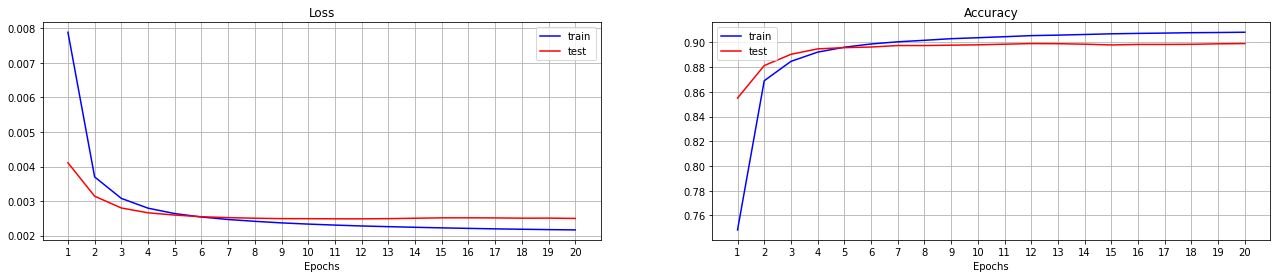

In [ ]:
plt.figure(figsize=(22,4))
x = [i for i in range(1,21)]

plt.subplot(1,2, 1)
plt.title("Loss")
plt.xlabel("Epochs")
plt.xticks(x)
plt.plot( x ,train_loss, color='blue', label='train')
plt.plot( x ,val_loss, color='red', label='test') 
plt.grid()
plt.legend();

plt.subplot(1,2, 2)
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.xticks(x)
plt.plot( x, train_acc, color='blue', label='train')
plt.plot( x, val_acc, color='red', label='test') 
plt.grid()
plt.legend() ;

 ## **Model Inference**

In [ ]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=10)
batch = next(iter(test_loader))
images = batch[0].to('cuda')
labels = batch[1].to('cuda')
print(images.shape)
print(labels.shape)
preds = model(images)
print(preds.shape)

preds = preds.argmax(dim=1)
print(preds.shape)

print(preds)
print(labels)


torch.Size([10, 1, 28, 28])
torch.Size([10])
torch.Size([10, 10])
torch.Size([10])
tensor([7, 2, 1, 0, 0, 1, 0, 0, 6, 0], device='cuda:0')
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], device='cuda:0')
